In [1]:
import numpy as np
import seaborn as sns
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

## Setup

We're going to do a quick experiment with bandits. Here's the setup:

$K = 2$ arms

$\mathcal{D}_i = \text{Bern}(\mu_i)$, $\mu_i \sim \text{Unif}(0, 1)$

We have a couple objectives to consider. The first is the classic MAB objective: $\max_a \mathbb{E}[R(a)]$. The second is the risk-averse objective $\max_a \frac{\mathbb E[R(a)]}{\mathbb{V}(R(a)) + \varepsilon}$.


In [40]:
# Sample policies

def exploit_only(t: int, T: int, K: int, history: List[Tuple[int, float]]) -> int:
    """
    A policy that always exploits the best action based on the history.
    
    Parameters:
    history (List[Tuple[int, float]]): The history of actions and rewards.
    
    Returns:
    int: The action to take.
    """
    if not history:
        return 0  # Default action if no history
    
    rewards: Dict[List[int]] = {}
    for action, reward in history:
        if action not in rewards:
            rewards[action] = []
        rewards[action].append(reward)
    
    avg_rewards = {action: np.mean(rewards[action]) for action in rewards}

    # Get key of best action
    best_action = max(avg_rewards, key=avg_rewards.get)     

    return best_action

def explore_only(t: int, T: int, K: int, history: List[Tuple[int, float]]) -> int:
    """
    A policy that always explores by taking a random action.
    
    Parameters:
    history (List[Tuple[int, float]]): The history of actions and rewards.
    
    Returns:
    int: A random action to take.
    """
    return np.random.randint(0,K)

def UCB(t: int, T: int, K: int, history: List[Tuple[int, float]]) -> int:
    """
    Upper Confidence Bound (UCB) policy.
    
    Parameters:
    t (int): Current time step.
    T (int): Total time steps.
    history (List[Tuple[int, float]]): The history of actions and rewards.
    
    Returns:
    int: The action to take based on UCB.
    """
    if not history:
        return 0  # Default action if no history
    
    actions = [action for action, _ in history]
    counts = {action: actions.count(action) for action in set(actions)}
    
    # Calculate the average reward for each action
    avg_rewards = {action: np.mean([reward for a, reward in history if a == action]) for action in counts}
    
    # UCB calculation
    ucb_values = {action: avg_rewards[action] + (1 + np.sqrt((2 * np.log(t))) / (1 + counts[action])) for action in counts}
    
    best_action = max(ucb_values, key=ucb_values.get)
    # print(best_action)
    
    return best_action

In [41]:
# Sample objective functions
def classic_MAB(rewards: List[float]) -> float:
    """
    Classic Multi-Armed Bandit objective function.
    
    Parameters:
    rewards (List[float]): A list of rewards obtained from the simulation.
    
    Returns:
    float: The average reward.
    """
    return np.mean(rewards)

def sharpe_robust(rewards: List[float], epsilon: float = 0.0) -> float:
    """
    Robust Sharpe ratio objective function.
    
    Parameters:
    rewards (List[float]): A list of rewards obtained from the simulation.
    
    Returns:
    float: The robust Sharpe ratio.
    """
    mean_reward = np.mean(rewards)
    var_reward = np.var(rewards)
    
    if var_reward == 0:
        return 0.0
    
    return mean_reward / (var_reward + epsilon)

In [62]:
#  Helper functions for simulations

def simulate(policy, T: int, history, distns):
    """
    Simulate a policy over T time steps.
    """
    reward = 0
    K = len(distns)
    
    for t in range(1, T+1):
        action = policy(t, T, K, history)
        reward_t = np.random.binomial(1, distns[action])
        history.append((action, reward_t))
        reward += reward_t

    return reward, history


def gen_history(actions: List[int], distns) -> List[Tuple[int, float]]:
    """
    Generate a history of actions and rewards.
    
    Parameters:
    actions (List[int]): A list of actions taken.
    
    Returns:
    List[Tuple[int, float]]: A list of tuples where each tuple contains an action and its corresponding reward.
    """
    history = []
    for action in actions:
        reward = np.random.binomial(1, distns[action])
        history.append((action, reward))

    return history

def compute_fitness(policies, objective_fns, history, distns, T: int, n_iter=100) -> List[List[int]]:
    K = len(distns)
    return_values: List[List[int]] = list()

    for policy in policies:
        if not callable(policy):
            raise ValueError("Each policy must be a callable function.")

        objectives: List[List[int]] = list()
        rewards: List[float] = list()

        for _ in range(n_iter):
            reward, _ = simulate(policy, T=T, history=history, distns=distns)
            rewards.append(reward)

        objectives = [objective_fn(rewards) for objective_fn in objective_fns]
        return_values.append(objectives)
        # print(f"Policy: {policy.__name__}, Rewards: {rewards}, Objectives: {objectives}")

    return return_values

In [ ]:
objective_fns = [classic_MAB, sharpe_robust, lambda rewards: sharpe_robust(rewards, epsilon=10)]
policies = [explore_only, exploit_only]

T_range = np.arange(1, 10)
distns = [1.0, 0.0]
history = gen_history([0, 1], distns)

# Simulate the policies
fitnesses = []

for T in T_range:
    history = []
    fitness = compute_fitness(policies, objective_fns, history, distns, T=T, n_iter=1000)
    fitnesses.append(fitness)

fitnesses = np.array(fitnesses)
fitnesses.shape # (T_range, policies, objectives)


(9, 2, 3)

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: >

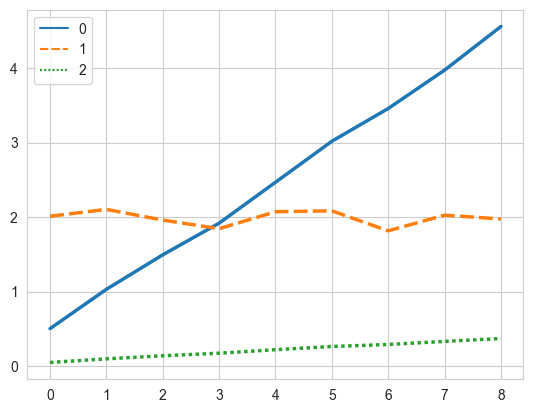

In [67]:
fitnesses = np.array(fitnesses)

sns.lineplot(data=fitnesses[:, 0, :], palette="tab10", linewidth=2.5)